# Analysis of Abl mutations in Perses

Below is a first draft of some inital analysis of `4xey` mutations (E255K). This is still in test phase.

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
# Load and combine arrays
forward_complex_arrays = []
reverse_complex_arrays = []
forward_apo_arrays = []
reverse_apo_arrays = []

for j in tqdm_notebook(range(100)):
    print(f"job: {j}")
    forward_complex_path = f'/data/chodera/glassw/kinoml/Abl/run_neq/4xey/E255K/4xey_dasatinib_E255K_complex_{j}_forward.npy'
    reverse_complex_path = f'/data/chodera/glassw/kinoml/Abl/run_neq/4xey/E255K/4xey_dasatinib_E255K_complex_{j}_reverse.npy'
    forward_apo_path = f'/data/chodera/glassw/kinoml/Abl/run_neq/4xey/E255K/4xey_dasatinib_E255K_apo_{j}_forward.npy'
    reverse_apo_path = f'/data/chodera/glassw/kinoml/Abl/run_neq/4xey/E255K/4xey_dasatinib_E255K_apo_{j}_reverse.npy'
    if os.path.exists(forward_complex_path):
        with open(forward_complex_path, 'rb') as f:
            forward_complex_arrays.append(np.load(f))
    if os.path.exists(reverse_complex_path):
        with open(reverse_complex_path, 'rb') as f:
            reverse_complex_arrays.append(np.load(f))
    if os.path.exists(forward_apo_path):
        with open(forward_apo_path, 'rb') as f:
            forward_apo_arrays.append(np.load(f))
    if os.path.exists(reverse_apo_path):
        with open(reverse_apo_path, 'rb') as f:
            reverse_apo_arrays.append(np.load(f))
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    reverse_apo_combined = np.concatenate(reverse_apo_arrays)


# Substract offset
forward_work_offset_complex = []
for cycle in forward_complex_combined:
    forward_work_offset_complex.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset_complex = np.array(forward_work_offset_complex)

reverse_work_offset_complex = []
for cycle in reverse_complex_combined:
    reverse_work_offset_complex.append(np.array([val - cycle[0] for val in cycle[1:]]))
reverse_work_offset_complex = np.array(reverse_work_offset_complex)

forward_work_offset_apo = []
for cycle in forward_apo_combined:
    forward_work_offset_apo.append(np.array([val - cycle[0] for val in cycle[1:]]))
forward_work_offset_apo = np.array(forward_work_offset_apo)

reverse_work_offset_apo = []
for cycle in reverse_apo_combined:
    reverse_work_offset_apo.append(np.array([val - cycle[0] for val in cycle[1:]]))
reverse_work_offset_apo = np.array(reverse_work_offset_apo)

/home/glassw/miniconda/envs/ntrk_mutations_and_perses_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


job: 0
job: 1
job: 2
job: 3
job: 4
job: 5
job: 6
job: 7
job: 8
job: 9
job: 10
job: 11
job: 12
job: 13
job: 14
job: 15
job: 16
job: 17
job: 18
job: 19
job: 20
job: 21
job: 22
job: 23
job: 24
job: 25
job: 26
job: 27
job: 28
job: 29
job: 30
job: 31
job: 32
job: 33
job: 34
job: 35
job: 36
job: 37
job: 38
job: 39
job: 40
job: 41
job: 42
job: 43
job: 44
job: 45
job: 46
job: 47
job: 48
job: 49
job: 50
job: 51
job: 52
job: 53
job: 54
job: 55
job: 56
job: 57
job: 58
job: 59
job: 60
job: 61
job: 62
job: 63
job: 64
job: 65
job: 66
job: 67
job: 68
job: 69
job: 70
job: 71
job: 72
job: 73
job: 74
job: 75
job: 76
job: 77
job: 78
job: 79
job: 80
job: 81
job: 82
job: 83
job: 84
job: 85
job: 86
job: 87
job: 88
job: 89
job: 90
job: 91
job: 92
job: 93
job: 94
job: 95
job: 96
job: 97
job: 98
job: 99



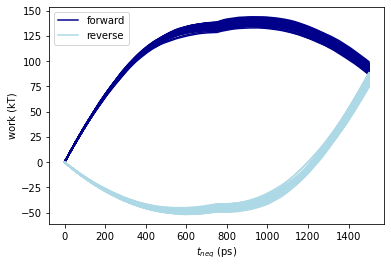

In [3]:
# Plot work trajectories for complex
for i, cycle in enumerate(forward_work_offset_complex):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
        plt.plot(x, y, color='darkblue', label='forward')
    else:
        plt.plot(x, y, color='darkblue')
for i, cycle in enumerate(reverse_work_offset_complex):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
         plt.plot(x, -y, color='lightblue', label='reverse')
    else:
        plt.plot(x, -y, color='lightblue')
plt.legend(loc='best')
plt.xlabel("$t_{neq}$ (ps)")
plt.ylabel("work (kT)")
plt.show()

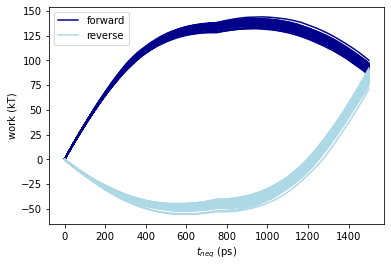

In [4]:
# Plot work trajectories for apo
for i, cycle in enumerate(forward_work_offset_apo):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
        plt.plot(x, y, color='darkblue', label='forward')
    else:
        plt.plot(x, y, color='darkblue')
for i, cycle in enumerate(reverse_work_offset_apo):
    x = [(i+1)*4e-3 for i in range(len(list(cycle)))]
    y = cycle
    if i == 0:
         plt.plot(x, -y, color='lightblue', label='reverse')
    else:
        plt.plot(x, -y, color='lightblue')
plt.legend(loc='best')
plt.xlabel("$t_{neq}$ (ps)")
plt.ylabel("work (kT)")
plt.show()